# PyMEOS Demo for ACM Demo

In [1]:
from datetime import timedelta
from functools import partial

import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import shapely as shp
from pymeos import *
from pymeos.plotters import *
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
pymeos_initialize()

## Preprocessing

In [ ]:
ais = pd.read_csv('ais.csv')
ais.head()

We preprocess the row data so that:
- Rows that have null values in `MMSI`, `Timestamp`, `SOG`, `COG`, `Latitude` or `Longitude` are deleted.
- Timestamps are converted from strings to `datetime` objects.
- Rows that are not in the range [(-16.1, 40.18), (32.88, 84.73)] (bounds of EPSG:25832) are deleted.
- Rows are dropped so that no row has the same timestamp and MMSI than another.
- A new column with Shapely Points is generated.

In [ ]:
ais = ais[['MMSI', '# Timestamp', 'SOG', 'COG', 'Latitude', 'Longitude']].dropna()
ais['# Timestamp'] = pd.to_datetime(ais['# Timestamp'], format='%d/%m/%Y %H:%M:%S')
ais = ais[(ais['Latitude'] >= 40.18) & (ais['Latitude'] <= 84.73) &
          (ais['Longitude'] >= -16.1) & (ais['Longitude'] <= 32.88)]
ais = ais.drop_duplicates(['# Timestamp', 'MMSI'])
ais['Geom'] = shp.points(ais['Longitude'], ais['Latitude'])
ais.head()

Then, a new `DataFrame` is generated (`ships`) with the same index as the previous one `ais`

In [ ]:
ships = ais[['MMSI', '# Timestamp']].copy()

PyMEOS instant objects are created for `SOG`, `COG` and `Geom`.

In [ ]:
ships['SOG'] = ais.progress_apply(lambda row: TFloatInst(value=row['SOG'], timestamp=row['# Timestamp']), axis=1)
ships['COG'] = ais.progress_apply(lambda row: TFloatInst(value=row['COG'], timestamp=row['# Timestamp']), axis=1)
ships['Geom'] = ais.progress_apply(
    lambda row: TGeomPointInst(point=row['Geom'], timestamp=row['# Timestamp'], srid=25832), axis=1)
ships.head()

Rows are sorted by Timestamp and aggregated by MMSI, aggregating the columns in a list.

In [ ]:
ships = ships.sort_values(by='# Timestamp').groupby('MMSI').agg(list)
ships.head()

Instants are merged into PyMEOS sequence objects (the upper bound are set to be inclusive to avoid an error when there is only one instant).

In [ ]:
ships['SOG'] = ships['SOG'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
ships['COG'] = ships['COG'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
ships['Trip'] = ships['Geom'].progress_apply(lambda x: TGeomPointSeq(instant_list=x, upper_inc=True).set_srid(25832))

We store the DataFrame in a csv file to save the processing.
Sequence objects need to be transformed to text to be able to be parsed later.
HexWKB format is chosen here.

In [ ]:
s = ships[['MMSI', 'SOG', 'COG', 'Trip']].copy()
s['SOG'] = s['SOG'].apply(lambda x: x.as_hexwkb())
s['COG'] = s['COG'].apply(lambda x: x.as_hexwkb())
s['Trip'] = s['Trip'].apply(lambda x: x.as_hexwkb())
s.to_csv('ships.csv')

## Extracting Ferries

In [108]:
ships = pd.read_csv('ships.csv', converters={
    'SOG': TFloatSeq.from_hexwkb,
    'COG': TFloatSeq.from_hexwkb,
    'Trip': partial(TGeomPointSeq.from_hexwkb, srid=25832)
})

We now plot the sequences in a map to take an overall look at them. Note that, logically, the vast majority of the sequences are over Denmark.

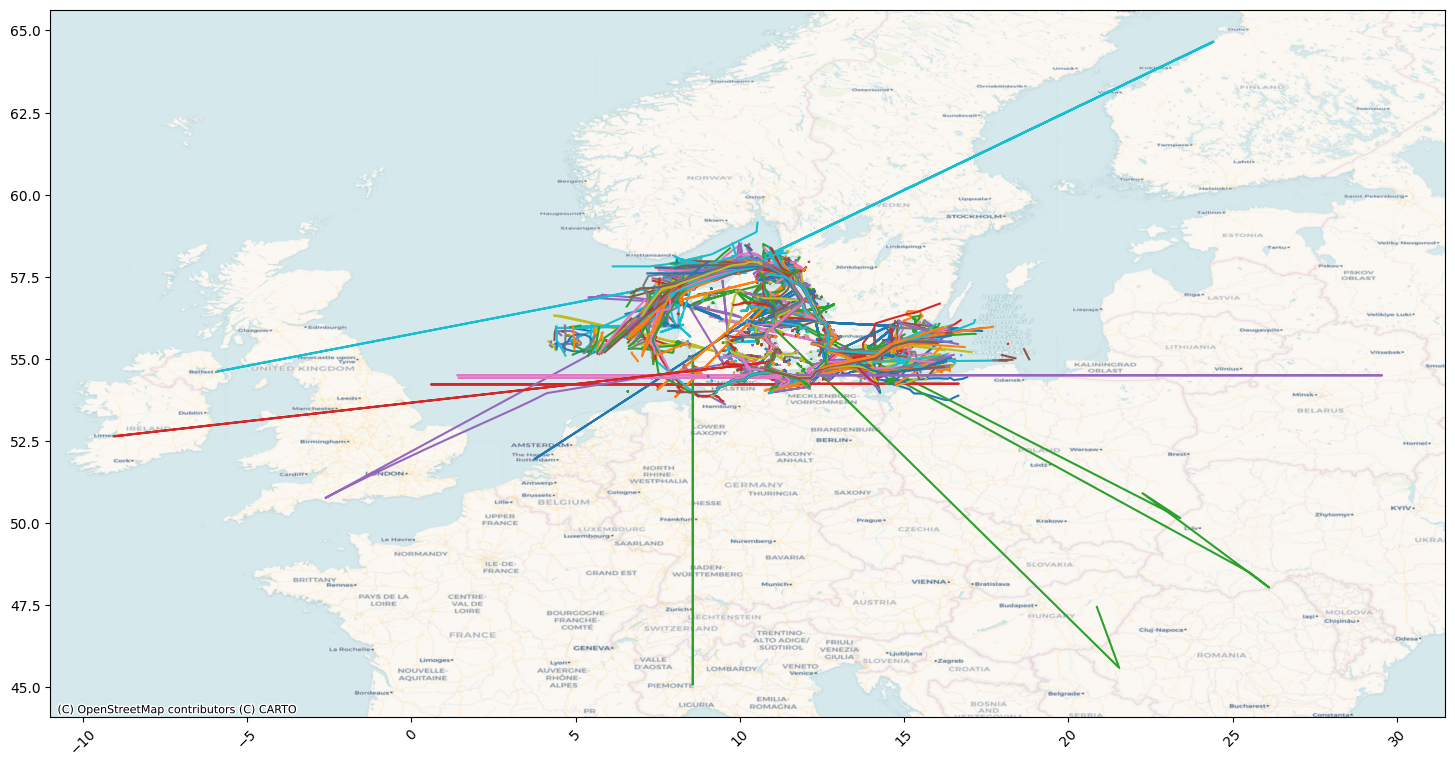

In [115]:
_, ax = plt.subplots(figsize=(18, 10))
_ = TemporalPointSequencePlotter.plot_sequences_xy(ships['Trip'], axes=ax, show_markers=False, show_grid=False)
_ = cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.Voyager)

In this demo we will work over the ferries that do the route Rodby (Denmark) <-> Puttgarden (Germany), so we'll start creating a bounding box for each port.
We start by manually getting two points, one for each port, and creating a box for each. Then, we expand this bounding boxes.
From these two boxes we create another one that contains both. We'll use this bigger one ase a prefilter to detect the ferries.

In [116]:
rodby = shp.set_srid(shp.Point(11.347317, 54.651643), 25832)
puttgarden = shp.set_srid(shp.Point(11.231497, 54.505600), 25832)

rodby_bb = STBox.from_geometry(rodby).expand(0.005)
puttgarden_bb = STBox.from_geometry(puttgarden).expand(0.005)

joined = rodby_bb.expand(puttgarden_bb)

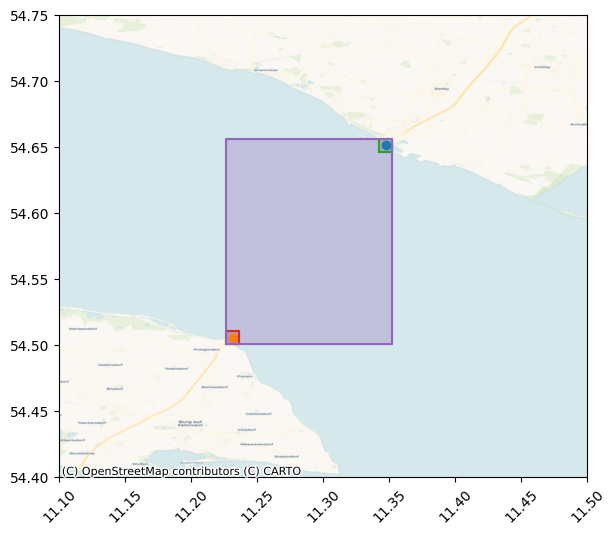

In [117]:
_, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(54.4, 54.75)
ax.set_xlim(11.1, 11.5)
_ = ax.plot(rodby.x, rodby.y, marker="o")
_ = ax.plot(puttgarden.x, puttgarden.y, marker="o")
_ = rodby_bb.plot_xy(axes=ax, label='Rodby')
_ = puttgarden_bb.plot_xy(axes=ax, label='Puttgarden')
_ = joined.plot_xy(axes=ax, label='Joined BBox')
_ = cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.Voyager)

Now we will use these bounding boxes to keep only the trips that correspond to ferries doing the Rodby <-> Puttgarden route.
First, we filter out the trips that doesn't go intersect the bigger bounding box.

In [118]:
intersect_index = ships['Trip'].progress_apply(lambda trip: trip.ever_intersects(joined))
possible_ferries = ships[intersect_index]
non_ferries = ships[~intersect_index]

  0%|          | 0/2732 [00:00<?, ?it/s]

Then, we filter the ferries by selecting those trips that pass through the bounding boxes of both ports.

In [119]:
ferries_index = possible_ferries['Trip'].progress_apply(lambda trip: trip.ever_intersects(rodby_bb)
                                                                     and trip.ever_intersects(puttgarden_bb))
ferries = possible_ferries[ferries_index]
non_ferries_intersect = possible_ferries[~ferries_index]

  0%|          | 0/136 [00:00<?, ?it/s]

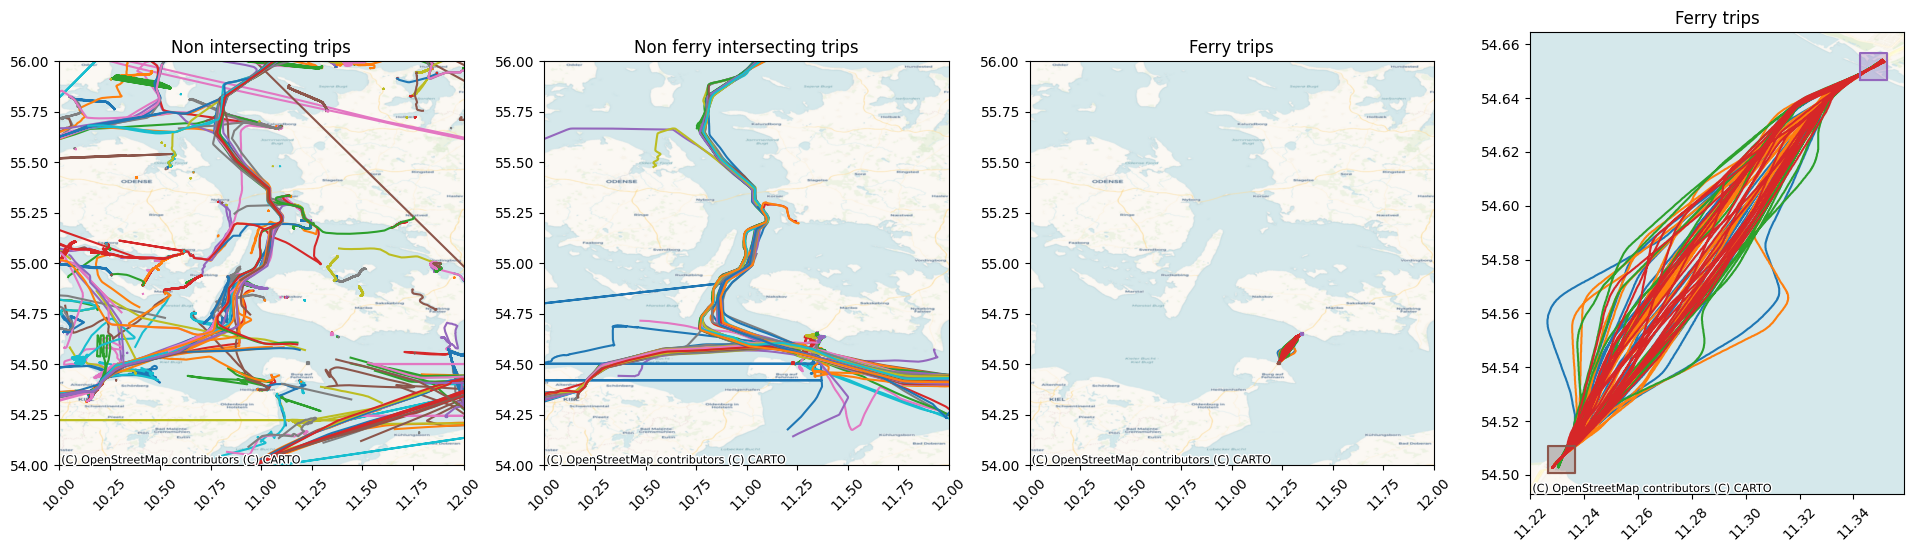

In [120]:
_, ax = plt.subplots(1, 4, figsize=(24, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(non_ferries['Trip'], axes=ax[0], show_markers=False, show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(non_ferries_intersect['Trip'], axes=ax[1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(ferries['Trip'], axes=ax[2], show_markers=False, show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(ferries['Trip'], axes=ax[3], show_markers=False, show_grid=False)
ax[0].set_title('Non intersecting trips')
ax[1].set_title('Non ferry intersecting trips')
ax[2].set_title('Ferry trips')
ax[3].set_title('Ferry trips')
for i in range(3):
    _ = rodby_bb.plot_xy(axes=ax[i])
    _ = puttgarden_bb.plot_xy(axes=ax[i])
    _ = ax[i].set_xlim(10, 12)
    _ = ax[i].set_ylim(54, 56)
    _ = cx.add_basemap(ax[i], crs=4326, source=cx.providers.CartoDB.Voyager)
_ = rodby_bb.plot_xy(axes=ax[3])
_ = puttgarden_bb.plot_xy(axes=ax[3])
_ = cx.add_basemap(ax[3], crs=4326, source=cx.providers.CartoDB.Voyager)

In [121]:
f = ferries[['MMSI', 'SOG', 'COG', 'Trip']].copy()
f['SOG'] = f['SOG'].apply(lambda x: x.as_hexwkb())
f['COG'] = f['COG'].apply(lambda x: x.as_hexwkb())
f['Trip'] = f['Trip'].apply(lambda x: x.as_hexwkb())
f.to_csv('ferries.csv', index=False)

nf = pd.concat([
    non_ferries[['MMSI', 'SOG', 'COG', 'Trip']].copy(),
    non_ferries_intersect[['MMSI', 'SOG', 'COG', 'Trip']].copy(),
])
nf['SOG'] = nf['SOG'].apply(lambda x: x.as_hexwkb())
nf['COG'] = nf['COG'].apply(lambda x: x.as_hexwkb())
nf['Trip'] = nf['Trip'].apply(lambda x: x.as_hexwkb())
nf.to_csv('non_ferries.csv', index=False)

In [122]:
ferries = pd.read_csv('ferries.csv', converters={
    'SOG': TFloatSeq.from_hexwkb,
    'COG': TFloatSeq.from_hexwkb,
    'Trip': partial(TGeomPointSeq.from_hexwkb, srid=25832)
})
non_ferries = pd.read_csv('non_ferries.csv', converters={
    'SOG': TFloatSeq.from_hexwkb,
    'COG': TFloatSeq.from_hexwkb,
    'Trip': partial(TGeomPointSeq.from_hexwkb, srid=25832)
})

## Splitting ferry trajectories into trips between ports

We now split the ferry trajectories into single trips between Rodby and Puttgarden trips. To do so, we explore two different methods: using the ports geometries and using the `stops` method.

### Port geometry method
Here we use the bounding boxes of the ports we created earlier to get individual trajectories for every ferry trip in the route Rodby <-> Puttgarden.
We obtain these trajectories using with the following process:
- Using the method `is_spatially_contained_in` available for `TGeomPoint` subclasses, we obtain two `TBoolSeq`s, one for when the trajectory is inside Rodby and another one with Puttgarden.
- We merge these two boolean sequences using the `temporal_or` method of `TBool`.
- We obtain the time (as a `PeriodSet`) when the ferry was travelling (i.e. neither inside Rodby nor Puttgarden) using the `when_false` method of `TBool`.
- We compute the travels by clipping the whole trajectory using the `PeriodSet` obtained in the previous setp using the `at` method.
- We separate the Sequence sets into single sequences using the `sequences` method, and create a row for each sequence using the `explode` method of `DataFrame`.
- We clip the `SOG` and `COG` sequences to the single trip.

In [60]:
geometry_ferries = ferries.copy()
geometry_ferries['Time Outside'] = geometry_ferries['Trip'].apply(
    lambda trip: trip.is_spatially_contained_in(rodby_bb).temporal_or(
        trip.is_spatially_contained_in(puttgarden_bb)).when_false())
geometry_ferries['Single Trips'] = geometry_ferries.apply(lambda row: row['Trip'].at(row['Time Outside']), axis=1)

In [61]:
geometry_ferries.head()

,SOG,COG,Trip,MMSI,Time Outside,Single Trips
0,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,0,"{[2023-04-25 00:02:29+02, 2023-04-25 00:39:36....",{[POINT(11.236 54.5106)@2023-04-25 00:02:29+02...
1,"[16@2023-04-25 00:00:00+02, 16@2023-04-25 00:0...","[221@2023-04-25 00:00:00+02, 221@2023-04-25 00...","[POINT(11.2557 54.575)@2023-04-25 00:00:00+02,...",1,"{[2023-04-25 00:00:00+02, 2023-04-25 00:15:46....",{[POINT(11.2557 54.575)@2023-04-25 00:00:00+02...
2,"[0@2023-04-25 00:00:11+02, 0@2023-04-25 02:26:...","[320@2023-04-25 00:00:11+02, 320@2023-04-25 00...",[POINT(11.2304 54.5029)@2023-04-25 00:00:11+02...,2,"{[2023-04-25 02:30:48.5+02, 2023-04-25 03:09:0...",{[POINT(11.23515 54.5106)@2023-04-25 02:30:48....
3,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,3,"{[2023-04-25 00:15:58.521666+02, 2023-04-25 00...",{[POINT(11.342317000036363 54.64874466669091)@...


In [65]:
geometry_single_ferry_trips = geometry_ferries[['MMSI', 'Single Trips', 'SOG', 'COG']].copy()
geometry_single_ferry_trips['Single Trips'] = geometry_single_ferry_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
geometry_single_ferry_trips = geometry_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                                         axis=1)
geometry_single_ferry_trips.insert(1, 'Trip #', geometry_single_ferry_trips.groupby('MMSI').cumcount() + 1)
geometry_single_ferry_trips.head()

,MMSI,Trip #,Trip,SOG,COG
0,0,1,"[POINT(11.236 54.5106)@2023-04-25 00:02:29+02,...","[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,2,[POINT(11.34231700005 54.648678000033335)@2023...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,3,[POINT(11.23554 54.510600000000004)@2023-04-25...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,4,[POINT(11.342317 54.6486302)@2023-04-25 02:57:...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,5,[POINT(11.2358 54.5106)@2023-04-25 04:03:22+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."


In [12]:
geometry_single_ferry_trips['SOG'] = geometry_single_ferry_trips.apply(lambda row: row['SOG'].at(row['Trip'].period()),
                                                                       axis=1)
geometry_single_ferry_trips['COG'] = geometry_single_ferry_trips.apply(lambda row: row['COG'].at(row['Trip'].period()),
                                                                       axis=1)
geometry_single_ferry_trips.head()

,MMSI,Trip,SOG,COG
0,0,"[POINT(11.236 54.5106)@2023-04-25 00:02:29+02,...","[12@2023-04-25 00:02:29+02, 12@2023-04-25 00:0...","[31@2023-04-25 00:02:29+02, 30@2023-04-25 00:0..."
0,0,[POINT(11.34231700005 54.648678000033335)@2023...,"[9@2023-04-25 00:58:41.659999+02, 9@2023-04-25...",[225.30499991666667@2023-04-25 00:58:41.659999...
0,0,[POINT(11.23554 54.510600000000004)@2023-04-25...,"[10.6@2023-04-25 02:00:59+02, 11@2023-04-25 02...","[27.8@2023-04-25 02:00:59+02, 27@2023-04-25 02..."
0,0,[POINT(11.342317 54.6486302)@2023-04-25 02:57:...,"[9@2023-04-25 02:57:46.66+02, 9@2023-04-25 02:...","[223.132@2023-04-25 02:57:46.66+02, 224@2023-0..."
0,0,[POINT(11.2358 54.5106)@2023-04-25 04:03:22+02...,"[12@2023-04-25 04:03:22+02, 12@2023-04-25 04:0...","[31@2023-04-25 04:03:22+02, 30@2023-04-25 04:0..."


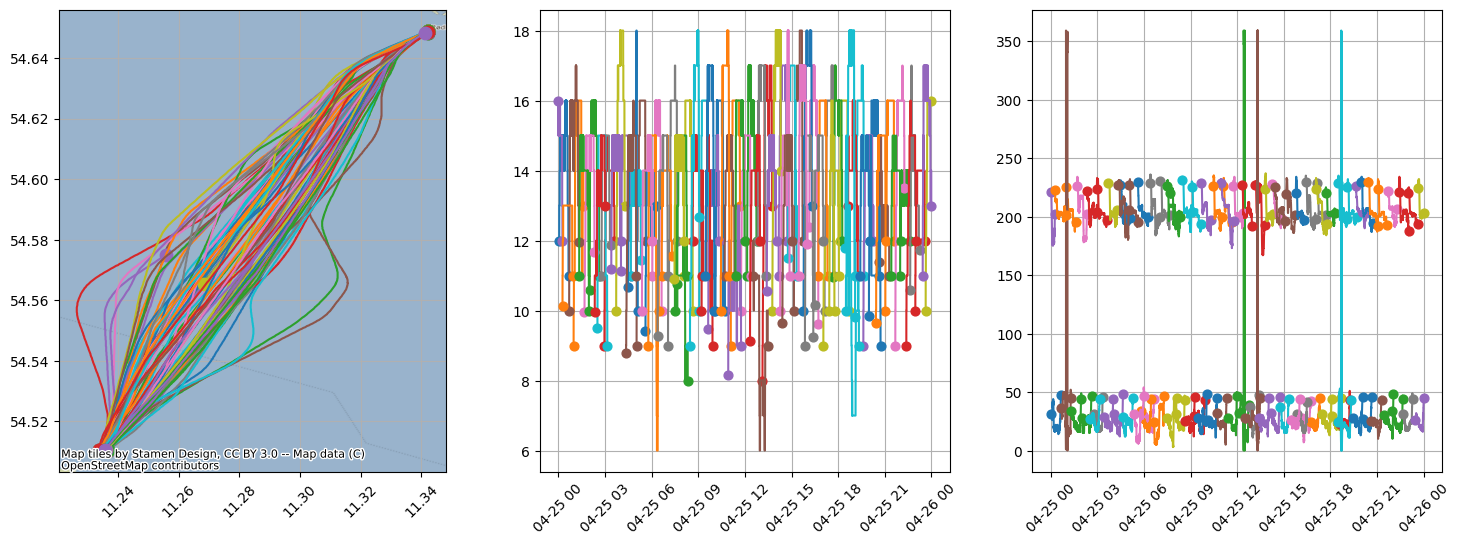

In [16]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['Trip'], axes=ax[0])
_ = cx.add_basemap(ax[0], crs=4326)

_ = TemporalSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['SOG'], axes=ax[1])
_ = TemporalSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['COG'], axes=ax[2])

### Stops method
Now, we split the trajectories using the `stops` method, which splits a trajectory into segments by splitting the trajectory at every stop (defined by a maximum distance moved in a certain amount of time).

In [54]:
stops_ferries = ferries.copy()
stops_ferries['Stops'] = stops_ferries['Trip'].apply(lambda trip: trip.stops(0.0025, timedelta(minutes=10)).time())
stops_ferries['Single Trips'] = stops_ferries.apply(lambda row: row['Trip'].minus(row['Stops']).sequences(), axis=1)
stops_ferries.head()

,SOG,COG,Trip,MMSI,Stops,Single Trips
0,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,0,"{[2023-04-25 01:46:33+02, 2023-04-25 01:57:42+...",[[POINT(11.2304 54.5053)@2023-04-25 00:00:08+0...
1,"[16@2023-04-25 00:00:00+02, 16@2023-04-25 00:0...","[221@2023-04-25 00:00:00+02, 221@2023-04-25 00...","[POINT(11.2557 54.575)@2023-04-25 00:00:00+02,...",1,"{[2023-04-25 00:26:56+02, 2023-04-25 00:38:18+...",[[POINT(11.2557 54.575)@2023-04-25 00:00:00+02...
2,"[0@2023-04-25 00:00:11+02, 0@2023-04-25 02:26:...","[320@2023-04-25 00:00:11+02, 320@2023-04-25 00...",[POINT(11.2304 54.5029)@2023-04-25 00:00:11+02...,2,"{[2023-04-25 00:00:11+02, 2023-04-25 02:28:24+...",[(POINT(11.2312 54.5051)@2023-04-25 02:28:24+0...
3,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,3,"{[2023-04-25 00:02:18+02, 2023-04-25 00:13:38+...",[[POINT(11.3424 54.6487)@2023-04-25 00:00:08+0...


In [73]:
stops_single_ferry_trips = stops_ferries[['MMSI', 'Single Trips', 'SOG', 'COG']].copy()
stops_single_ferry_trips = stops_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'}, axis=1)
stops_single_ferry_trips.insert(1, 'Trip #', stops_single_ferry_trips.groupby('MMSI').cumcount() + 1)
stops_single_ferry_trips.head()

,MMSI,Trip #,Trip,SOG,COG
0,0,1,[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,2,(POINT(11.2295 54.5043)@2023-04-25 01:57:42+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,3,(POINT(11.2301 54.5052)@2023-04-25 04:01:02+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,4,(POINT(11.2293 54.5042)@2023-04-25 05:59:14+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,5,(POINT(11.3492 54.6525)@2023-04-25 07:00:44+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."


In [74]:
stops_single_ferry_trips['SOG'] = stops_single_ferry_trips.apply(lambda row: row['SOG'].at(row['Trip'].period()),
                                                                 axis=1)
stops_single_ferry_trips['COG'] = stops_single_ferry_trips.apply(lambda row: row['COG'].at(row['Trip'].period()),
                                                                 axis=1)
stops_single_ferry_trips.head()

,MMSI,Trip #,Trip,SOG,COG
0,0,1,[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0..."
0,0,2,(POINT(11.2295 54.5043)@2023-04-25 01:57:42+02...,"(4@2023-04-25 01:57:42+02, 5@2023-04-25 01:57:...","(27@2023-04-25 01:57:42+02, 27@2023-04-25 01:5..."
0,0,3,(POINT(11.2301 54.5052)@2023-04-25 04:01:02+02...,"(7@2023-04-25 04:01:02+02, 7@2023-04-25 04:01:...","(26@2023-04-25 04:01:02+02, 27@2023-04-25 04:0..."
0,0,4,(POINT(11.2293 54.5042)@2023-04-25 05:59:14+02...,"(4@2023-04-25 05:59:14+02, 5@2023-04-25 05:59:...","(26@2023-04-25 05:59:14+02, 26@2023-04-25 05:5..."
0,0,5,(POINT(11.3492 54.6525)@2023-04-25 07:00:44+02...,"(3@2023-04-25 07:00:44+02, 4@2023-04-25 07:00:...","(226@2023-04-25 07:00:44+02, 224@2023-04-25 07..."


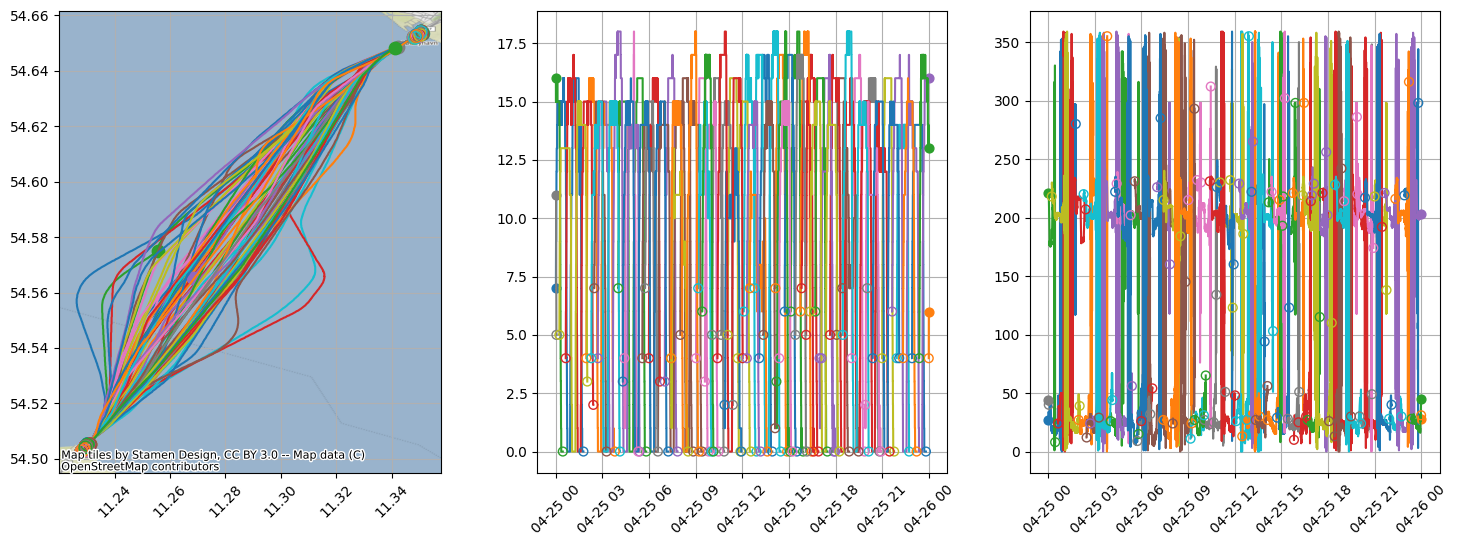

In [58]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

_ = TemporalPointSequencePlotter.plot_sequences_xy(stops_single_ferry_trips['Trip'], axes=ax[0])
_ = cx.add_basemap(ax[0], crs=4326)

_ = TemporalSequencePlotter.plot_sequences_xy(stops_single_ferry_trips['SOG'], axes=ax[1])
_ = TemporalSequencePlotter.plot_sequences_xy(stops_single_ferry_trips['COG'], axes=ax[2])

## Trajectory metrics

Now we will compute several metrics over the ferries' trips

In [103]:
single_trips = stops_single_ferry_trips.copy()
ship_metrics = pd.DataFrame(index=single_trips['MMSI'].unique())

In [104]:
single_trips['Trip Distance'] = single_trips['Trip'].apply(lambda trip: trip.length())
total_distance = single_trips.groupby('MMSI')['Trip Distance'].sum()
ship_metrics = pd.concat([ship_metrics, total_distance], axis=1)
total_distance

MMSI
0    4.774056
1    4.809830
2    2.412480
3    4.749586
Name: Trip Distance, dtype: float64

In [105]:
single_trips['Average Speed'] = single_trips['Trip'].apply(lambda trip: trip.speed().time_weighted_average())
single_trips['Average SOG'] = single_trips['SOG'].apply(lambda sog: sog.time_weighted_average())
single_trips

,MMSI,Trip #,Trip,SOG,COG,Trip Distance,Average Speed,Average SOG
0,0,1,[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",0.396027,0.000062,10.993892
0,0,2,(POINT(11.2295 54.5043)@2023-04-25 01:57:42+02...,"(4@2023-04-25 01:57:42+02, 5@2023-04-25 01:57:...","(27@2023-04-25 01:57:42+02, 27@2023-04-25 01:5...",0.397511,0.000060,10.519213
0,0,3,(POINT(11.2301 54.5052)@2023-04-25 04:01:02+02...,"(7@2023-04-25 04:01:02+02, 7@2023-04-25 04:01:...","(26@2023-04-25 04:01:02+02, 27@2023-04-25 04:0...",0.396047,0.000061,10.848293
0,0,4,(POINT(11.2293 54.5042)@2023-04-25 05:59:14+02...,"(4@2023-04-25 05:59:14+02, 5@2023-04-25 05:59:...","(26@2023-04-25 05:59:14+02, 26@2023-04-25 05:5...",0.193573,0.000075,13.491443
0,0,5,(POINT(11.3492 54.6525)@2023-04-25 07:00:44+02...,"(3@2023-04-25 07:00:44+02, 4@2023-04-25 07:00:...","(226@2023-04-25 07:00:44+02, 224@2023-04-25 07...",0.198594,0.000067,11.817705
...,...,...,...,...,...,...,...,...
3,3,12,(POINT(11.3483 54.6522)@2023-04-25 16:21:58+02...,"(6@2023-04-25 16:21:58+02, 6@2023-04-25 16:22:...","(219@2023-04-25 16:21:58+02, 220@2023-04-25 16...",0.399090,0.000059,10.340163
3,3,13,(POINT(11.3484 54.6519)@2023-04-25 18:27:39+02...,"(5@2023-04-25 18:27:39+02, 6@2023-04-25 18:27:...","(228@2023-04-25 18:27:39+02, 229@2023-04-25 18...",0.394750,0.000066,11.600866
3,3,14,(POINT(11.3489 54.6527)@2023-04-25 20:23:17+02...,"(4@2023-04-25 20:23:17+02, 4@2023-04-25 20:23:...","(217@2023-04-25 20:23:17+02, 217@2023-04-25 20...",0.392903,0.000064,11.277162
3,3,15,"(POINT(11.349 54.6526)@2023-04-25 22:20:26+02,...","(4@2023-04-25 22:20:26+02, 5@2023-04-25 22:20:...","(216@2023-04-25 22:20:26+02, 220@2023-04-25 22...",0.198145,0.000063,11.100859


In [106]:
average_sog = single_trips.groupby('MMSI')['Average SOG'].mean()
ship_metrics = pd.concat([ship_metrics, average_sog], axis=1)
average_sog

MMSI
0    11.668846
1    11.474803
2    10.361608
3    11.490807
Name: Average SOG, dtype: float64

In [107]:
ship_metrics

,Trip Distance,Average SOG
0,4.774056,11.668846
1,4.809830,11.474803
2,2.412480,10.361608
3,4.749586,11.490807


## Ships near ferries

Now we will identify the ships that came into a distance of less than 300 meters of each other

In [134]:
ferry_ships = pd.merge(ferries, non_ferries, how='cross', suffixes=(' Ferry', ' Ship'))
ferry_ships

,MMSI Ferry,SOG Ferry,COG Ferry,Trip Ferry,MMSI Ship,SOG Ship,COG Ship,Trip Ship
0,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,0,"[0@2023-04-25 00:00:01+02, 0@2023-04-25 23:59:...","[123@2023-04-25 00:00:01+02, 123@2023-04-25 00...",[POINT(12.3095 56.1258)@2023-04-25 00:00:01+02...
1,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,2190045,"[0@2023-04-25 00:00:06+02, 0@2023-04-25 23:59:...","[26@2023-04-25 00:00:06+02, 351@2023-04-25 00:...",[POINT(8.42338 55.4718)@2023-04-25 00:00:06+02...
2,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,69284660,[72@2023-04-25 09:24:36+02],[327@2023-04-25 09:24:36+02],[POINT(2.84857 55.1035)@2023-04-25 09:24:36+02]
3,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,97000070,"[7@2023-04-25 11:18:50+02, 7@2023-04-25 12:31:...","[136@2023-04-25 11:18:50+02, 136@2023-04-25 12...",[POINT(9.63823 57.6142)@2023-04-25 11:18:50+02...
4,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,109010166,"[0@2023-04-25 20:54:35+02, 0@2023-04-25 21:21:...","[0@2023-04-25 20:54:35+02, 0@2023-04-25 21:21:...",[POINT(10.4118 58.1854)@2023-04-25 20:54:35+02...
...,...,...,...,...,...,...,...,...
10907,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,636022255,"[6@2023-04-25 00:00:02+02, 6@2023-04-25 00:17:...","[237@2023-04-25 00:00:02+02, 237@2023-04-25 00...",[POINT(12.3458 54.6497)@2023-04-25 00:00:02+02...
10908,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,636022306,"[10@2023-04-25 00:00:07+02, 10@2023-04-25 00:0...","[217@2023-04-25 00:00:07+02, 218@2023-04-25 00...",[POINT(14.3538 55.2772)@2023-04-25 00:00:07+02...
10909,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,636022867,"[11@2023-04-25 00:00:04+02, 11@2023-04-25 00:4...","[250@2023-04-25 00:00:04+02, 250@2023-04-25 00...","[POINT(13.122 54.8852)@2023-04-25 00:00:04+02,..."
10910,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,636092769,"[13@2023-04-25 00:00:05+02, 13@2023-04-25 00:0...","[156@2023-04-25 00:00:05+02, 155@2023-04-25 00...",[POINT(11.0554 55.2781)@2023-04-25 00:00:05+02...


In [145]:
ferry_ships = ferry_ships[ferry_ships.progress_apply(lambda row: row['Trip Ferry'].is_ever_within_distance(row['Trip Ship'], 0.005), axis=1)]

  0%|          | 0/307 [00:00<?, ?it/s]

In [146]:
ferry_ships

,MMSI Ferry,SOG Ferry,COG Ferry,Trip Ferry,MMSI Ship,SOG Ship,COG Ship,Trip Ship
1053,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,219018788,"[0@2023-04-25 00:02:56+02, 0@2023-04-25 15:03:...","[342@2023-04-25 00:02:56+02, 342@2023-04-25 00...",[POINT(11.3494 54.6571)@2023-04-25 00:02:56+02...
2604,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,211128920,"[0@2023-04-25 00:00:15+02, 0@2023-04-25 23:59:...","[123@2023-04-25 00:00:15+02, 123@2023-04-25 00...",[POINT(11.3455 54.6558)@2023-04-25 00:00:15+02...
2614,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,219000431,"[0@2023-04-25 00:00:10+02, 0@2023-04-25 04:39:...","[10@2023-04-25 00:00:10+02, 255@2023-04-25 00:...",[POINT(11.2268 54.5027)@2023-04-25 00:00:10+02...
2615,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,219002801,"[0@2023-04-25 00:00:01+02, 0@2023-04-25 23:59:...","[198@2023-04-25 00:00:01+02, 160@2023-04-25 00...","[POINT(11.352 54.6516)@2023-04-25 00:00:01+02,..."
2616,211188000,"[7@2023-04-25 00:00:08+02, 7@2023-04-25 00:00:...","[27@2023-04-25 00:00:08+02, 27@2023-04-25 00:0...",[POINT(11.2304 54.5053)@2023-04-25 00:00:08+02...,219007462,"[0@2023-04-25 00:00:29+02, 0@2023-04-25 23:58:...","[15@2023-04-25 00:00:29+02, 15@2023-04-25 00:0...",[POINT(11.3483 54.6565)@2023-04-25 00:00:29+02...
...,...,...,...,...,...,...,...,...
10834,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,245140000,"[0@2023-04-25 00:02:14+02, 0@2023-04-25 23:59:...","[268@2023-04-25 00:02:14+02, 268@2023-04-25 00...",[POINT(11.3503 54.6563)@2023-04-25 00:02:14+02...
10837,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,245693000,"[0@2023-04-25 00:00:03+02, 0@2023-04-25 05:42:...","[42@2023-04-25 00:00:03+02, 42@2023-04-25 05:4...",[POINT(11.3481 54.6553)@2023-04-25 00:00:03+02...
10842,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,246607000,"[0@2023-04-25 00:00:01+02, 0@2023-04-25 00:00:...","[271@2023-04-25 00:00:01+02, 263@2023-04-25 00...",[POINT(11.3765 54.6388)@2023-04-25 00:00:01+02...
10844,219000429,"[11@2023-04-25 00:00:08+02, 11@2023-04-25 00:0...","[44@2023-04-25 00:00:08+02, 44@2023-04-25 00:0...",[POINT(11.3424 54.6487)@2023-04-25 00:00:08+02...,246812000,"[0@2023-04-25 00:00:03+02, 0@2023-04-25 04:50:...","[21@2023-04-25 00:00:03+02, 66@2023-04-25 00:0...","[POINT(11.351 54.6568)@2023-04-25 00:00:03+02,..."


In [148]:
close_ferries = ferry_ships['Trip Ferry'].drop_duplicates()
close_ships = ferry_ships['Trip Ship'].drop_duplicates()

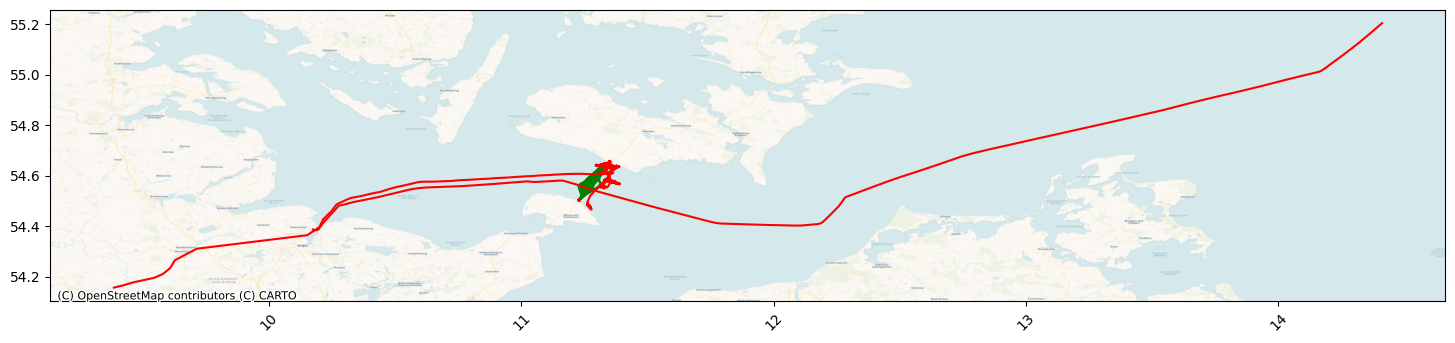

In [155]:
_, ax = plt.subplots(figsize=(18, 9))
_ = TemporalPointSequencePlotter.plot_sequences_xy(close_ferries, axes=ax, show_markers=False, show_grid=False, color='green')
_ = TemporalPointSequencePlotter.plot_sequences_xy(close_ships, axes=ax, show_markers=False, show_grid=False, color='red')
_ = cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.Voyager)

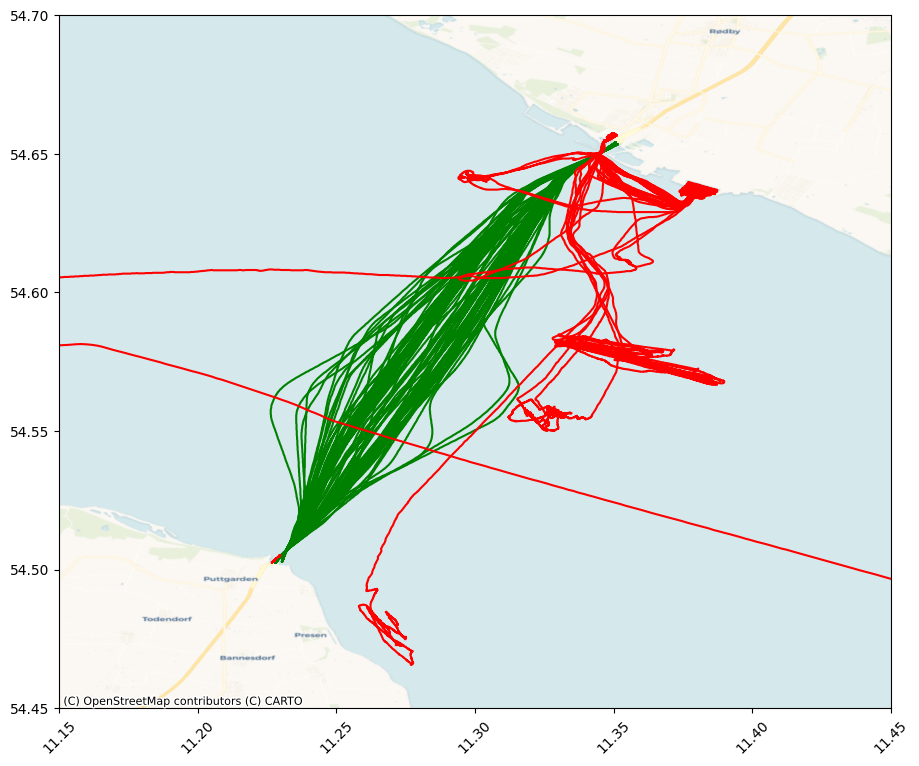

In [159]:
_, ax = plt.subplots(figsize=(18, 9))
ax.set_xlim(11.15, 11.45)
ax.set_ylim(54.45, 54.7)
_ = TemporalPointSequencePlotter.plot_sequences_xy(close_ferries, axes=ax, show_markers=False, show_grid=False, color='green')
_ = TemporalPointSequencePlotter.plot_sequences_xy(close_ships, axes=ax, show_markers=False, show_grid=False, color='red')
_ = cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.Voyager)

## Cleanup

In [ ]:
# pymeos_finalize()